In [1]:
import sqlite3
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from utils.performance_utils import get_cdf_comparison_visualization_df

params = {
    'axes.labelsize'  : 15.5,
    "font.family": "sans-serif",
    'axes.titlesize'  : 15.5,
    'font.size'       : 14,
    'legend.fontsize' : 13,
    'xtick.labelsize' : 13,
    'ytick.labelsize' : 13
}
plt.rcParams.update(params)
plt.rcParams.update({'figure.max_open_warning': 0})

%matplotlib inline

## *RQ1:* How much effort does it take for human annotators to generate segmentations for cell images of varying detail using GrabCut as an interactive segmentation approach?

Effort:

* Mean maximum `submission_counter` per `image_id`
* Time per submission per `image_id` per `session_id`
* For Kromp dataset: Percentage of annotated pixels compared to ground truth mask.

In [2]:
q = '''select * from interactions'''
conn = sqlite3.connect('grabcutstudy.db')

images_df = pd.read_sql_query('''select * from images''', conn)
respondents_df = pd.read_sql_query('''select * from respondents''', conn)
interactions_df = pd.read_sql_query('''select * from interactions''', conn, parse_dates=['first_interaction_time', 'submission_time'])
masks_df = pd.read_sql_query('''select * from masks''', conn)
interactions_with_submission_df = pd.read_sql_query('''select * from interactionswithsubmissions''', conn)
conn.close()

image_categories = ['lym0', 'lym17', 'neu0', 'neu12', 'neu90', 'agg17', 'agg23', 'agg185', 'neurblas5', 'neurblas10', 'neurblas16', 'normal2', 'normal4']
imgs = pd.api.types.CategoricalDtype(ordered=True, categories=image_categories)

In [3]:
print(f'IAR: \t{len(interactions_df)} segmentations requested')
print(f'Masks: \t{len(masks_df)} masks created')

IAR: 	873 segmentations requested
Masks: 	304 masks created


In [5]:
interactions_df.head()

,interaction_uuid,session_id,image_id,annotated_pixels,foreground_pixels,background_pixels,scribbles,foreground_scribbles,background_scribbles,submission_counter,first_interaction_time,submission_time,difficulty,cell_count
0,2e394d13-9041-483e-b566-10df0b6762ca,buma1augyolmgo3vgr65wp8umbdphu8377ga3xtp5mgkz1...,lym17,3247,169,3078,2,1,1,1,2021-09-16 10:04:44,2021-09-16 10:04:55,Easy,1
1,1ae4644c-1577-4650-b435-a95bc07b12bc,buma1augyolmgo3vgr65wp8umbdphu8377ga3xtp5mgkz1...,lym17,3582,169,3413,3,1,2,2,2021-09-16 10:04:44,2021-09-16 10:07:23,Easy,1
2,36806b84-560a-4494-90ab-2371dca6992c,n3vrj2k41nfxztngvnx4jkru8g95xu5xnxfl5xf98zinie...,lym17,612,10,602,2,1,1,1,2021-09-20 10:07:45,2021-09-20 10:07:58,Easy,1
3,a2b30077-ca25-4164-9beb-2386fbfe0d51,n3vrj2k41nfxztngvnx4jkru8g95xu5xnxfl5xf98zinie...,lym17,3362,10,3352,3,1,2,2,2021-09-20 10:07:45,2021-09-20 10:08:55,Easy,1
4,75195106-2186-4813-aa56-7609573a30d7,n3vrj2k41nfxztngvnx4jkru8g95xu5xnxfl5xf98zinie...,lym17,3394,72,3322,4,2,2,3,2021-09-20 10:07:45,2021-09-20 10:09:54,Easy,1


In [6]:
masks_df.head()

,mask_uuid,session_id,image_id,mask,interaction_uuid
0,9e25ad11-7d96-4b17-a80f-06c93d4d6d4e,buma1augyolmgo3vgr65wp8umbdphu8377ga3xtp5mgkz1...,lym17,"4,149,150,151,210,224,225,226,227,239,240,241,...",1ae4644c-1577-4650-b435-a95bc07b12bc
1,e57b8fa9-77af-46ba-9ce4-b2004f9ab805,buma1augyolmgo3vgr65wp8umbdphu8377ga3xtp5mgkz1...,neu12,"268,269,311,353,354,382,383,62396,62397,62398,...",3cabef95-4f65-4d61-87c4-0872f4a2252e
2,ee6bbf30-1428-4be3-af34-0b20f65e89c8,buma1augyolmgo3vgr65wp8umbdphu8377ga3xtp5mgkz1...,agg185,"122,123,210,324,325,707,11096,11097,11098,1109...",21e0e38f-abd8-4468-ad1d-fb034850df7f
3,54158809-ecdb-4c57-8964-c2d50ea0924a,buma1augyolmgo3vgr65wp8umbdphu8377ga3xtp5mgkz1...,normal2,"329,330,331,332,333,334,335,336,337,338,339,34...",8a999cdd-8e7e-4ac6-bb87-cd8cee583349
4,2e51ba65-0ac5-49af-b170-5faef00a7d5f,7qrj02gvqzolp023brrn5hy7aax2yeye71suikl55om6yj...,lym0,"134297,134298,134299,134300,134301,134302,1348...",b7fd9dd7-209b-4207-b01e-7321715d6426


In [7]:
interactions_df['first_interaction_time'] = pd.to_datetime(interactions_df['first_interaction_time'])
interactions_df['submission_time'] = pd.to_datetime(interactions_df['submission_time'])

interactions_with_submission_df['first_interaction_time'] = pd.to_datetime(interactions_with_submission_df['first_interaction_time'])
interactions_with_submission_df['submission_time'] = pd.to_datetime(interactions_with_submission_df['submission_time'])

In [8]:
interactions_with_submission_df.head()

,interaction_uuid,session_id,image_id,annotated_pixels,foreground_pixels,background_pixels,scribbles,foreground_scribbles,background_scribbles,submission_counter,first_interaction_time,submission_time,submitted_mask_uuid,submitted_mask,difficulty,cell_count
0,2e394d13-9041-483e-b566-10df0b6762ca,buma1augyolmgo3vgr65wp8umbdphu8377ga3xtp5mgkz1...,lym17,3247,169,3078,2,1,1,1,2021-09-16 10:04:44,2021-09-16 10:04:55,9e25ad11-7d96-4b17-a80f-06c93d4d6d4e,"4,149,150,151,210,224,225,226,227,239,240,241,...",Easy,1
1,1ae4644c-1577-4650-b435-a95bc07b12bc,buma1augyolmgo3vgr65wp8umbdphu8377ga3xtp5mgkz1...,lym17,3582,169,3413,3,1,2,2,2021-09-16 10:04:44,2021-09-16 10:07:23,9e25ad11-7d96-4b17-a80f-06c93d4d6d4e,"4,149,150,151,210,224,225,226,227,239,240,241,...",Easy,1
2,53d31b96-05c1-4178-b2d1-2758abd37e93,d2tajxer3fhgs05uxnqm2x4b22xqquntakf9i53pzwred8...,lym17,1023,55,968,2,1,1,1,2021-09-20 10:54:58,2021-09-20 10:55:02,906c3f5f-0e6e-4469-8ed3-e7e971f142fd,"69224,69225,69226,69227,69228,69733,69734,6973...",Easy,1
3,4f678c81-43f0-4e31-bf7b-68d9f4ae3714,4tr3jou7weyntnomg8dq17y8sfjzsn2bvdq1w8a2s8apjl...,lym17,1304,52,1252,2,1,1,1,2021-09-20 10:58:27,2021-09-20 10:58:31,86cfff11-1db9-4fa3-aee3-e2059094dee3,"225,68711,68712,68713,68714,68715,68716,68717,...",Easy,1
4,b47dfc62-687a-428e-9447-199edb64b010,rm21kawqmj3567ts9lshyo0poj83t235oqjykcsl73nnn2...,lym17,1433,27,1406,2,1,1,1,2021-09-20 11:14:01,2021-09-20 11:14:16,fa493786-bf12-4dbd-908d-6afe7a248c64,"225,68711,68712,68713,68714,68715,68716,68717,...",Easy,1


In [9]:
# Only process images where the participants have actually submitted their mask
interactions_for_masks_df = pd.merge(interactions_df, masks_df, how="inner", on=["interaction_uuid"])
interactions_for_masks_df['annotated_pixels_percentage'] = interactions_for_masks_df['annotated_pixels'] / (384 * 512)

print(f'{len(interactions_for_masks_df)} masks with available interaction record.')

304 masks with available interaction record.


In [10]:
interactions_for_masks_df = interactions_for_masks_df.rename(columns={
    'session_id_x': 'session_id',
    'image_id_x': 'image_id',
    'submission_time': 'mask_creation_time',
    'submission_counter': 'segmentation_attempts',
})

del interactions_for_masks_df['session_id_y']
del interactions_for_masks_df['image_id_y']

interactions_for_masks_df.dtypes

interaction_uuid                       object
session_id                             object
image_id                               object
annotated_pixels                        int64
foreground_pixels                       int64
background_pixels                       int64
scribbles                               int64
foreground_scribbles                    int64
background_scribbles                    int64
segmentation_attempts                   int64
first_interaction_time         datetime64[ns]
mask_creation_time             datetime64[ns]
difficulty                             object
cell_count                              int64
mask_uuid                              object
mask                                   object
annotated_pixels_percentage           float64
dtype: object

In [11]:
interactions_final_segmentation_df = interactions_with_submission_df.loc[interactions_with_submission_df.groupby(['session_id', 'image_id'])['submission_counter'].idxmax()]
interactions_final_segmentation_df = interactions_final_segmentation_df.rename(columns={
    'submission_counter': 'total_submissions',
    'submission_time': 'finishing_time',
})

interactions_final_segmentation_df = interactions_final_segmentation_df.assign(first_interaction_time=pd.to_datetime(interactions_final_segmentation_df['first_interaction_time']))
interactions_final_segmentation_df = interactions_final_segmentation_df.assign(finishing_time=pd.to_datetime(interactions_final_segmentation_df['finishing_time']))
interactions_final_segmentation_df['interaction_duration'] = interactions_final_segmentation_df['finishing_time'] - interactions_final_segmentation_df['first_interaction_time']
interactions_final_segmentation_df = interactions_final_segmentation_df.assign(
    interaction_duration=interactions_final_segmentation_df['interaction_duration'].dt.total_seconds().astype('int32')
)
interactions_final_segmentation_df['first_interaction_time'] = pd.to_datetime(interactions_final_segmentation_df['first_interaction_time'])
interactions_final_segmentation_df = interactions_final_segmentation_df.assign(finishing_time=pd.to_datetime(interactions_final_segmentation_df['finishing_time']))

interactions_final_segmentation_df['interaction_duration'] = interactions_final_segmentation_df['finishing_time'] - interactions_final_segmentation_df['first_interaction_time']

interactions_final_segmentation_df['interaction_duration'] = interactions_final_segmentation_df['interaction_duration'].dt.total_seconds().astype('int32')

In [12]:
# Give interaction duration to dataframe containing masks
session_durations = interactions_final_segmentation_df[['session_id', 'image_id', 'interaction_duration', 'total_submissions']].copy()
interactions_for_masks_df = pd.merge(interactions_for_masks_df, session_durations, how='inner', on=['session_id', 'image_id'])

In [13]:
interactions_with_submission_df = interactions_with_submission_df.assign(image_id=interactions_with_submission_df['image_id'].astype(imgs))
interactions_for_masks_df = interactions_for_masks_df.assign(image_id=interactions_for_masks_df['image_id'].astype(imgs))
interactions_final_segmentation_df = interactions_final_segmentation_df.assign(image_id=interactions_final_segmentation_df['image_id'].astype(imgs))

In [14]:
interactions_with_submission_df.dtypes

interaction_uuid                  object
session_id                        object
image_id                        category
annotated_pixels                   int64
foreground_pixels                  int64
background_pixels                  int64
scribbles                          int64
foreground_scribbles               int64
background_scribbles               int64
submission_counter                 int64
first_interaction_time    datetime64[ns]
submission_time           datetime64[ns]
submitted_mask_uuid               object
submitted_mask                    object
difficulty                        object
cell_count                         int64
dtype: object

In [15]:
interactions_for_masks_df.tail()

,interaction_uuid,session_id,image_id,annotated_pixels,foreground_pixels,background_pixels,scribbles,foreground_scribbles,background_scribbles,segmentation_attempts,first_interaction_time,mask_creation_time,difficulty,cell_count,mask_uuid,mask,annotated_pixels_percentage,interaction_duration,total_submissions
299,ce4cad42-615b-4d47-b1a1-c1b59315e355,53iyfhfsrwads1x0a6rc5llfotv2gugo6nolg31p09tb53...,neurblas16,12995,3066,9929,22,16,6,1,2021-09-30 09:05:31,2021-09-30 09:07:34,Difficult,16,9658e230-0f76-404e-a3bb-2ade9ab8b82a,"16445,16446,16447,16448,16449,16450,16451,1645...",0.066096,123,1
300,36d4c450-dcf4-4db0-8f39-f8b2963501c6,td38ke5xiyj33aav4vkwcj5t3bzwmlasstgdm5tcxe1qek...,neurblas16,187,43,144,4,3,1,1,2021-10-01 22:46:56,2021-10-01 22:47:19,Difficult,16,a1618294-b232-448b-a3d6-2df9f91970a0,"16957,16958,16959,16960,16961,16962,16963,1696...",0.000951,23,1
301,0b1aa19b-c06e-441c-8c05-bfb0e398286e,zeueg5tvull5wmet3uvjh8kcfo02u0l4cfha44kcz4qy18...,neurblas16,35773,617,35156,25,10,15,2,2021-10-04 11:50:05,2021-10-04 11:51:28,Difficult,16,e1627911-80bb-406d-b927-b7ac8db078fa,"17468,17469,17470,17471,17472,17473,17474,1747...",0.181951,83,2
302,08e4b7f6-7684-4e32-8786-b6b785c11740,4llfau3jfnvpx1xxgr5glnv5um0bm1qn0cehws2d12mk5p...,neurblas16,2396,1990,406,22,13,9,1,2021-10-04 14:14:55,2021-10-04 14:17:27,Difficult,16,c93d9aa9-3860-4707-94fb-92057ccb75e0,"16445,16446,16447,16448,16449,16450,16451,1645...",0.012187,266,2
303,773d0820-c9ad-40ca-96eb-1c6d66c89976,k22a8exoq40n57f8z3wois0sqjixc8de46ajvk80ivt59h...,neurblas16,10246,543,9703,5,4,1,1,2021-10-08 13:48:08,2021-10-08 13:48:31,Difficult,16,8a343d6c-ece0-4c58-ab7b-115473ba6a69,"16445,16446,16447,16448,16449,16450,16451,1645...",0.052114,23,1


In [16]:
interactions_final_segmentation_df

,interaction_uuid,session_id,image_id,annotated_pixels,foreground_pixels,background_pixels,scribbles,foreground_scribbles,background_scribbles,total_submissions,first_interaction_time,finishing_time,submitted_mask_uuid,submitted_mask,difficulty,cell_count,interaction_duration
716,3a4485f4-0a6d-4197-9afd-9c6b3af66d52,03fce9g1ry8f4rw6kp9qnpwnvjcauoxvuokz03mb3qm5sj...,agg17,3992,3099,893,47,44,3,6,2021-09-27 17:12:02,2021-09-27 17:17:14,e8c97214-0baf-4beb-b1de-6fc8270c582d,"62,63,64,121,122,123,226,227,323,324,325,352,6...",Noisy,3,312
348,771b49c2-2e7c-4de1-a19d-e2983b907c3a,03fce9g1ry8f4rw6kp9qnpwnvjcauoxvuokz03mb3qm5sj...,lym0,36142,356,35786,3,2,1,5,2021-09-27 16:57:52,2021-09-27 17:07:54,02ff2468-c500-4fb2-b4d8-3da5f86ae068,"2,3,209,210,211,212,239,240,241,242,267,268,26...",Easy,1,602
449,150f215c-a5c7-437f-9228-430afb02b115,03fce9g1ry8f4rw6kp9qnpwnvjcauoxvuokz03mb3qm5sj...,neu90,17027,2028,14999,7,5,2,2,2021-09-27 17:08:54,2021-09-27 17:11:21,f4747041-01e4-4080-bb1e-b0acb64e9407,"225,226,267,268,269,270,271,296,297,325,326,75...",Medium,4,147
786,f52cd57f-3945-4bfc-a9c0-86a7b3c1f115,03fce9g1ry8f4rw6kp9qnpwnvjcauoxvuokz03mb3qm5sj...,normal4,1185,851,334,10,6,4,1,2021-09-27 17:17:48,2021-09-27 17:18:24,92376add-d831-45c2-bbaf-2256a85d4175,"15332,15333,15334,15335,15336,15337,15338,1533...",Difficult,15,36
227,a2744021-d734-47ad-ae56-57581806934f,03ht4uuf1sz2muinw3ftvh8s49rq7g7g7n4xkyn15lr4t1...,agg185,3564,558,3006,23,19,4,4,2021-10-01 10:10:24,2021-10-01 10:12:54,d3f364c6-3e0b-4437-8340-60ceb2a39580,"122,123,180,210,211,212,213,323,324,325,514,70...",Noisy,3,150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
684,147fdb06-6d66-431b-98f3-60fb60bdf6a6,zh9dulwmv8ryxp6mxtp2xij0w81oblbawc6o3gk9sh8w15...,neurblas5,9263,6484,2779,38,30,8,3,2021-10-09 10:14:48,2021-10-09 10:17:11,e1aa17e5-9005-46ca-887e-2befd0175305,"31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,4...",Difficult,18,143
548,9c1cd2cf-6165-4fec-991c-f6a46bfa8ffc,zwb41qloebdotii9o4osveyjhapdllmfq16tbek8612ivu...,agg23,8883,4666,4217,30,29,1,3,2021-10-08 09:16:12,2021-10-08 09:18:52,3b254df4-e61d-4a76-abe3-1beb0776ec77,"122,123,166,169,170,171,172,173,174,175,176,17...",Noisy,2,160
103,ac85427f-2c7c-4924-8833-85a983cef10f,zwb41qloebdotii9o4osveyjhapdllmfq16tbek8612ivu...,lym17,10593,320,10273,2,1,1,1,2021-10-08 09:08:46,2021-10-08 09:09:16,0ad08cb4-afba-4880-816e-e8a3645e188c,"4,149,150,151,210,224,225,226,227,239,240,241,...",Easy,1,30
489,f2dd06ce-b9b9-4f1e-81df-9b8054a71d44,zwb41qloebdotii9o4osveyjhapdllmfq16tbek8612ivu...,neu90,23683,2819,20864,13,12,1,4,2021-10-08 09:12:45,2021-10-08 09:15:38,01ed7d59-dd4f-41a8-b0c6-5e44269b13ac,"225,226,267,268,269,270,271,296,297,325,326,75...",Medium,4,173


In [17]:
conn = sqlite3.connect('grabcutstudy.db')
print(f"[*] Connected to DB.")
interactions_for_masks_df.to_sql(name='interactionswithmask', con=conn, index=False, if_exists='replace')
interactions_with_submission_df.to_sql(name='interactionswithsubmissions', con=conn, index=False, if_exists='replace')
print(f"[*] Wrote to DB.")
conn.close()

[*] Connected to DB.
[*] Wrote to DB.


In [18]:
difficulties = ['Easy', 'Medium', 'Noisy', 'Difficult']
diff = pd.api.types.CategoricalDtype(ordered=True, categories=difficulties)

interactions_with_submission_df['difficulty'] = interactions_with_submission_df['difficulty'].astype(diff)
interactions_for_masks_df['difficulty'] = interactions_for_masks_df['difficulty'].astype(diff)
interactions_final_segmentation_df['difficulty'] = interactions_final_segmentation_df['difficulty'].astype(diff)

### Time per submission per `image_id` per `session_id`

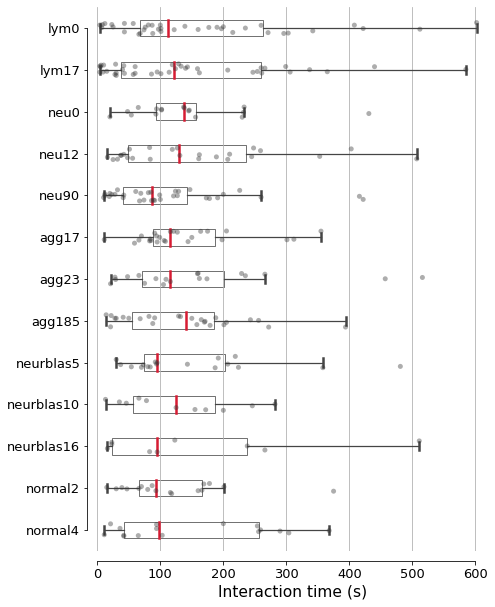

In [19]:
# sns.set_style("ticks")
sns.set_style({
    'xtick.top': False,
    'xtick.left': False,
    'ytick.right': False,
})

f, ax = plt.subplots(figsize=(7, 10))

PROPS = {
    'boxprops':{'facecolor':'none'},
    'medianprops':{'color':'#d71c33', 'linewidth': 2.5},
    'whiskerprops':{'linewidth': 1.25},
    'capprops':{'linewidth': 2.5}
}

b = sns.boxplot(y='image_id', x='interaction_duration', data=interactions_for_masks_df, showfliers = False, width=.4, whis=1.8, linewidth=0.75, **PROPS)

sns.stripplot(y='image_id', x='interaction_duration', data=interactions_for_masks_df, size=5, color=".2", alpha=.4, jitter=0.15)

ax.xaxis.grid(True)
ax.set(xlabel="Interaction time (s)")
ax.set(ylabel="")
ax.set_xlim([0, 620])
sns.despine(offset=10, trim=True)
# plt.xticks(rotation=15)

plt.savefig(f"plots/interaction_times.png", bbox_inches='tight')

In [20]:
difficulty_levels = ['Easy', 'Medium', 'Noisy', 'Difficult']

interactions_for_masks_crop3000_df = interactions_for_masks_df.drop(interactions_for_masks_df[interactions_for_masks_df['interaction_duration'] > 1400].index)

interaction_duration_cdf, interaction_duration_cdf_df = get_cdf_comparison_visualization_df(
    interactions_for_masks_df,
    # interactions_for_masks_crop3000_df,
    'interaction_duration',
    'difficulty',
    difficulty_levels
)

submission_count_cdf, submission_count_cdf_df = get_cdf_comparison_visualization_df(
    interactions_for_masks_df,
    # interactions_for_masks_crop3000_df,
    'total_submissions',
    'difficulty',
    difficulty_levels
)

[*] 84 records for difficulty == Easy
[*] 77 records for difficulty == Medium
[*] 72 records for difficulty == Noisy
[*] 71 records for difficulty == Difficult
[*] 84 records for difficulty == Easy
[*] 77 records for difficulty == Medium
[*] 72 records for difficulty == Noisy
[*] 71 records for difficulty == Difficult


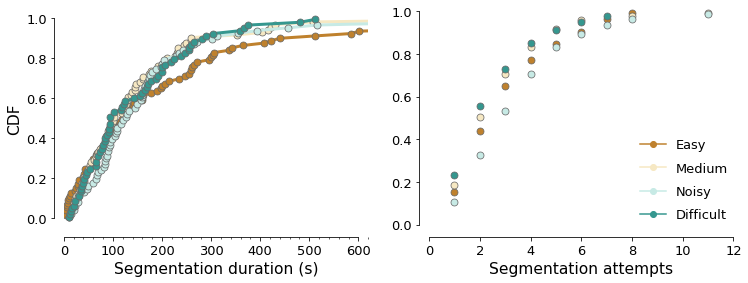

In [21]:
kromp_cmap = sns.color_palette("PRGn", 4)
# sns.palplot(kromp_cmap)

sns.set_style({
    'xtick.top': False,
    'ytick.right': False,
})

f, ax = plt.subplots(1, 2, figsize=(12, 4))

marker_style={
    'markeredgecolor': 'dimgrey'
}

sns.lineplot(
    data=interaction_duration_cdf_df,
    x='xs',
    y='ps',
    dashes=False,
    hue='difficulty', style='difficulty', ci=None, markers=['o', 'o', 'o', 'o'], linewidth=3, markersize=7, palette='BrBG', ax=ax[0], **marker_style
)

ax[0].set(ylabel="CDF")
ax[0].set(xlabel="Segmentation duration (s)")
ax[0].get_xaxis().set_minor_locator(ticker.AutoMinorLocator())
ax[0].set_xlim([0, 620])
ax[0].get_legend().remove()

sns.lineplot(
    data=submission_count_cdf_df,
    x='xs',
    y='ps',
    dashes=False,
    hue='difficulty', style='difficulty', ci=None, markers=['o', 'o', 'o', 'o'], linewidth=0, markersize=7, palette='BrBG', ax=ax[1], **marker_style
)

ax[1].set_ylim([-0.01, 1.01])
ax[1].set_xlim([0, 12])
ax[1].set(ylabel="")
ax[1].set(xlabel="Segmentation attempts")

l = plt.legend(loc='lower right', borderaxespad=0., labelspacing=0.8, frameon=False)
sns.despine(offset=10, trim=True)

plt.savefig(f"plots_png/duration_attempts_cdf.png", bbox_inches='tight')
plt.savefig(f"plots_pdf/duration_attempts_cdf.pdf", format='pdf', bbox_inches='tight')
plt.show()

In [22]:
t = 120
print(f'p_easy(t <= {t}) = {interaction_duration_cdf[0].Prob(t)}')
print(f'p_medium(t <= {t}) = {interaction_duration_cdf[1].Prob(t)}')
print(f'p_noisy(t <= {t}) = {interaction_duration_cdf[2].Prob(t)}')
print(f'p_difficult(t <= {t}) = {interaction_duration_cdf[3].Prob(t)}')

t = 240
print(f'p_easy(t > {t}) = {1 - interaction_duration_cdf[0].Prob(t)}')
print(f'p_medium(t > {t}) = {1 - interaction_duration_cdf[1].Prob(t)}')
print(f'p_noisy(t > {t}) = {1 - interaction_duration_cdf[2].Prob(t)}')
print(f'p_difficult(t > {t}) = {1 - interaction_duration_cdf[3].Prob(t)}')

print(np.mean([1 - interaction_duration_cdf[1].Prob(t), 1 - interaction_duration_cdf[2].Prob(t), 1 - interaction_duration_cdf[3].Prob(t)]))

t = 600
print(f'p_easy(t > {t}) = {1 - interaction_duration_cdf[0].Prob(t)}')
print(f'p_medium(t > {t}) = {1 - interaction_duration_cdf[1].Prob(t)}')
print(f'p_noisy(t > {t}) = {1 - interaction_duration_cdf[2].Prob(t)}')
print(f'p_difficult(t > {t}) = {1 - interaction_duration_cdf[3].Prob(t)}')

p_easy(t <= 120) = 0.5
p_medium(t <= 120) = 0.5324675324675324
p_noisy(t <= 120) = 0.4861111111111111
p_difficult(t <= 120) = 0.5633802816901409
p_easy(t > 240) = 0.29761904761904767
p_medium(t > 240) = 0.1428571428571429
p_noisy(t > 240) = 0.16666666666666663
p_difficult(t > 240) = 0.18309859154929575
0.16420746702436842
p_easy(t > 600) = 0.0714285714285714
p_medium(t > 600) = 0.012987012987012991
p_noisy(t > 600) = 0.02777777777777779
p_difficult(t > 600) = 0.0


In [23]:
s = 2
print(f'p_easy(s > {s}) = {1 - submission_count_cdf[0].Prob(s)}')

print(f'Avg seg. attempts for easy: {submission_count_cdf[0].Mean()}')
print(f'Avg seg. attempts for medium: {submission_count_cdf[1].Mean()}')
print(f'Avg seg. attempts for noisy: {submission_count_cdf[2].Mean()}')
print(f'Avg seg. attempts for difficult: {submission_count_cdf[3].Mean()}')

p_easy(s > 2) = 0.4285714285714286
Avg seg. attempts for easy: 2.7738095238095237
Avg seg. attempts for medium: 2.4675324675324677
Avg seg. attempts for noisy: 3.263888888888889
Avg seg. attempts for difficult: 2.2816901408450705


### Percentages of annotated pixels (compared to ground truth)

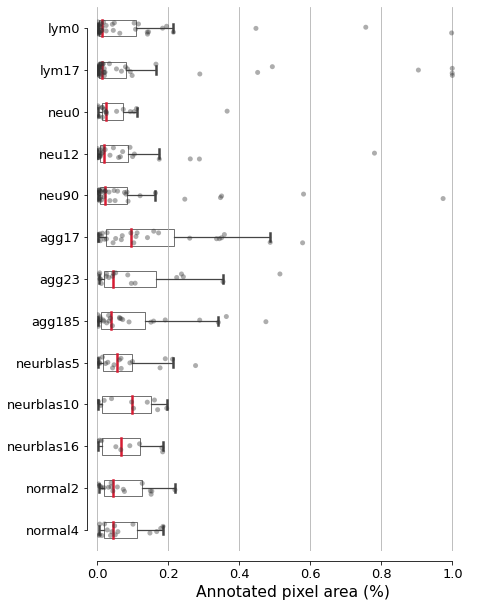

In [24]:
sns.set_style({
    'xtick.top': False,
    'ytick.right': False,
})

f, ax = plt.subplots(figsize=(7, 10))

PROPS = {
    'boxprops':{'facecolor':'none'},
    'medianprops':{'color':'#d71c33', 'linewidth': 2.5},
    'whiskerprops':{'linewidth': 1.25},
    'capprops':{'linewidth': 2.5}
}

sns.boxplot(y='image_id', x='annotated_pixels_percentage', data=interactions_for_masks_df, showfliers = False, width=.4, whis=1.8, linewidth=0.75, **PROPS)

sns.stripplot(y='image_id', x='annotated_pixels_percentage', data=interactions_for_masks_df, size=5, color=".2", alpha=.4, jitter=0.15)

ax.xaxis.grid(True)
ax.set(xlabel="Annotated pixel area (%)")
ax.set(ylabel="")
ax.set_xlim([0, 1.1])
sns.despine(offset=10, trim=True)
# plt.xticks(rotation=15)

plt.savefig(f"plots/annotated_pixels_percentage.png", bbox_inches='tight')

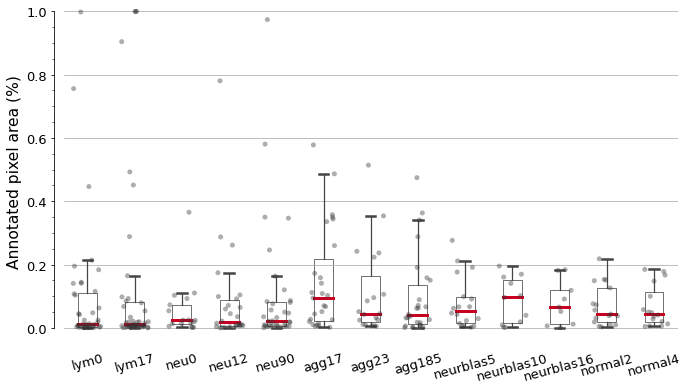

In [25]:
sns.set_style({
    'xtick.top': False,
    'ytick.right': False,
    'xtick.bottom': False,
})

f, ax = plt.subplots(figsize=(11, 6))

PROPS = {
    'boxprops':{'facecolor':'none'},
    'medianprops':{'color':'#ca0020', 'linewidth': 3},
    'whiskerprops':{'linewidth': 1.25},
    'capprops':{'linewidth': 2.5},
}

sns.boxplot(x='image_id', y='annotated_pixels_percentage', data=interactions_for_masks_df, showfliers = False, width=.4, whis=1.8, linewidth=0.75, **PROPS)

sns.stripplot(x='image_id', y='annotated_pixels_percentage', data=interactions_for_masks_df, size=5, color=".2", alpha=.4, jitter=0.3)

ax.yaxis.grid(True)
ax.get_yaxis().set_minor_locator(ticker.AutoMinorLocator())

ax.set(ylabel="Annotated pixel area (%)")
ax.set(xlabel="")
ax.set_ylim([-0.02, 1.01])
sns.despine(offset=10, trim=True)
plt.xticks(rotation=15)
ax.spines['bottom'].set_visible(False)

plt.savefig(f"plots_png/annotated_pixels_percentage.png", bbox_inches='tight')
plt.savefig(f"plots_pdf/annotated_pixels_percentage.pdf", format='pdf', bbox_inches='tight')


In [26]:
kromp_gt = np.load('kromp_gt.npz')

# keys = ['neurblas5', 'neurblas16', 'neurblas10', 'normal2', 'normal4']

d = {
    'image_id': ['neurblas5', 'neurblas10', 'neurblas16', 'normal2', 'normal4'],
    'bg_pixels': [
        np.count_nonzero(kromp_gt['neurblas5'] == 0),
        np.count_nonzero(kromp_gt['neurblas10'] == 0),
        np.count_nonzero(kromp_gt['neurblas16'] == 0),
        np.count_nonzero(kromp_gt['normal2'] == 0),
        np.count_nonzero(kromp_gt['normal4'] == 0),
    ],
    'fg_pixels': [
        np.count_nonzero(kromp_gt['neurblas5'] == 1),
        np.count_nonzero(kromp_gt['neurblas10'] == 1),
        np.count_nonzero(kromp_gt['neurblas16'] == 1),
        np.count_nonzero(kromp_gt['normal2'] == 1),
        np.count_nonzero(kromp_gt['normal4'] == 1),
    ],
}

gt_pixels_df = pd.DataFrame(data=d)

gt_pixels_df.head()

,image_id,bg_pixels,fg_pixels
0,neurblas5,174842,21766
1,neurblas10,179498,17110
2,neurblas16,183531,13077
3,normal2,158889,37719
4,normal4,178095,18513


In [27]:
gt_percentages_df = pd.merge(interactions_for_masks_df, gt_pixels_df, how="inner", on="image_id")

gt_percentages_df = gt_percentages_df.rename(
    columns={'bg_pixels': 'background_pixels_gt', 'fg_pixels': 'foreground_pixels_gt'}
)

In [28]:
gt_percentages_df['annotated_fg_pixels_percentage'] = gt_percentages_df['foreground_pixels'] / gt_percentages_df['foreground_pixels_gt']

gt_percentages_df['annotated_bg_pixels_percentage'] = gt_percentages_df['background_pixels'] / gt_percentages_df['background_pixels_gt']

In [29]:
kromp_image_categories = ['neurblas5', 'neurblas10', 'neurblas16', 'normal2', 'normal4']
kromp_imgs = pd.api.types.CategoricalDtype(ordered=True, categories=kromp_image_categories)

gt_percentages_df['image_id'] = gt_percentages_df['image_id'].astype(kromp_imgs)

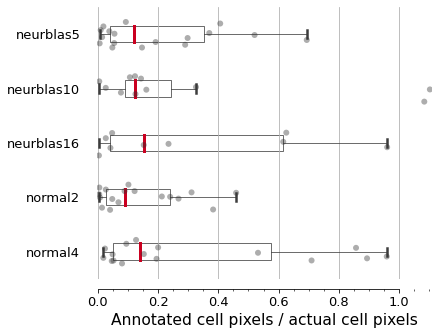

In [30]:
sns.set_style({
    'xtick.top': False,
    'xtick.bottom': True,
    'ytick.right': False,
    'ytick.left': False,
})

f, ax2 = plt.subplots(figsize=(6, 5))

PROPS = {
    'boxprops':{'facecolor':'none'},
    'medianprops':{'color':'#ca0020', 'linewidth': 3},
    'capprops':{'linewidth': 2.5}
}

b = sns.boxplot(y='image_id', x='annotated_fg_pixels_percentage', data=gt_percentages_df, showfliers = False, width=.3, linewidth=0.75, whis=1.8, ax=ax2, **PROPS)

sns.stripplot(y='image_id', x='annotated_fg_pixels_percentage', data=gt_percentages_df, size=6, color=".2", alpha=.4, jitter=0.25, ax=ax2)

ax2.xaxis.grid(True)
ax2.get_xaxis().set_minor_locator(ticker.AutoMinorLocator())

ax2.set(xlabel="Annotated cell pixels / actual cell pixels")
ax2.set(ylabel="")
ax2.set_xlim([-0.002, 1.11])
sns.despine(offset=10, trim=True)
ax2.spines['left'].set_visible(False)

plt.savefig(f"plots_png/kromp_annotated_fg.png", bbox_inches='tight')
plt.savefig(f"plots_pdf/kromp_annotated_fg.pdf", format='pdf', bbox_inches='tight')

plt.show()

In [31]:
#TODO find out who colored more than 100% of the foreground pixels

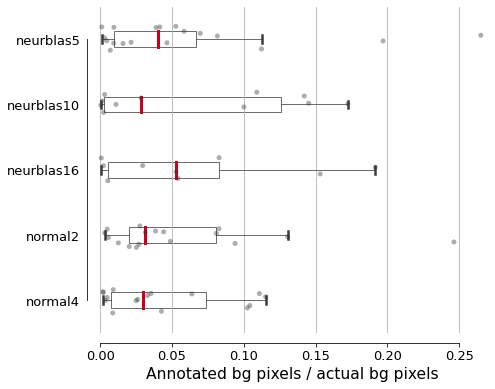

In [32]:
sns.set_style({
    'xtick.top': False,
    'ytick.right': False,
})

f, ax = plt.subplots(figsize=(7, 6))

b = sns.boxplot(y='image_id', x='annotated_bg_pixels_percentage', data=gt_percentages_df, showfliers = False, width=.24, linewidth=0.75, whis=1.8, **PROPS)

sns.stripplot(y='image_id', x='annotated_bg_pixels_percentage', data=gt_percentages_df, size=5, color=".2", alpha=.4, jitter=0.2)

ax.xaxis.grid(True)
ax.set(xlabel="Annotated bg pixels / actual bg pixels")
ax.set(ylabel="")
ax.set_xlim([-0.002, 0.27])
sns.despine(offset=10, trim=True)

plt.savefig(f"plots/kromp_annotated_bg.png", bbox_inches='tight')

<ipython-input-33-877618598401>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(new_labels)


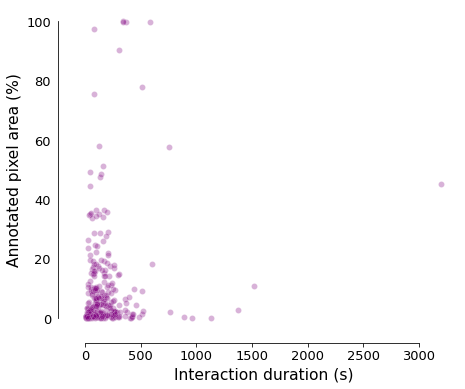

In [33]:
sns.set_style({
    'xtick.top': False,
    'ytick.right': False,
    'xtick.bottom': True,
})

f, ax = plt.subplots(figsize=(7, 6))


g = sns.scatterplot(x="interaction_duration", y="annotated_pixels_percentage",
                    alpha=.3,
                    sizes=(5, 5),
                    color="Purple",
                    data=interactions_for_masks_df, ax=ax)

ax.set(xlabel="Interaction duration (s)")
ax.set(ylabel="Annotated pixel area (%)")

new_labels = [i * 20 for i in range(6)]
ax.set_yticklabels(new_labels)

sns.despine(offset=10, trim=True)

plt.show()

In [34]:
from scipy import stats

In [35]:
duration = interactions_for_masks_df['interaction_duration'].values.tolist()
pixel_area = interactions_for_masks_df['annotated_pixels_percentage'].values.tolist()
corr_tuple = stats.mstats.spearmanr(duration, pixel_area, alternative='greater')

def compute_spearmanr(x, y):
    return stats.mstats.spearmanr(duration, pixel_area, alternative='greater')[0]

print(corr_tuple)

SpearmanrResult(correlation=0.18636343158495883, pvalue=0.0005480591624379805)


In [36]:
# rng = np.random.default_rng()
# res = stats.bootstrap((duration, pixel_area), compute_spearmanr, vectorized=False, paired=True, random_state=rng)
# print(res)

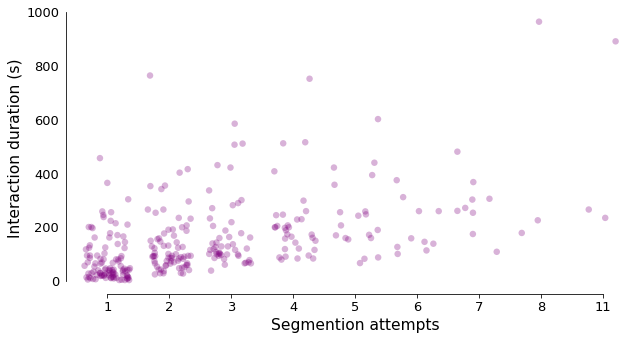

In [37]:
sns.set_style({
    'xtick.top': False,
    'ytick.right': False,
})

f, ax = plt.subplots(figsize=(10, 5))

sns.stripplot(
    y="interaction_duration", x="total_submissions",
    color="Purple",
    size=6.5,
    alpha=.3,
    data=interactions_for_masks_df, ax=ax,
    jitter=0.37
)

ax.set(ylabel="Interaction duration (s)")
ax.set(xlabel="Segmention attempts")

ax.set_ylim([-10, 1000])

sns.despine(offset=10, trim=True)

plt.savefig(f"plots_png/attempts_duration.png", bbox_inches='tight')
plt.savefig(f"plots_pdf/attempts_duration.pdf", format='pdf', bbox_inches='tight')
plt.show()

In [38]:
duration = interactions_for_masks_df['interaction_duration'].values.tolist()
attempts = interactions_for_masks_df['segmentation_attempts'].values.tolist()

print(stats.mstats.spearmanr(duration, attempts, alternative='greater'))

SpearmanrResult(correlation=0.5724483264419917, pvalue=3.6495674593276013e-28)


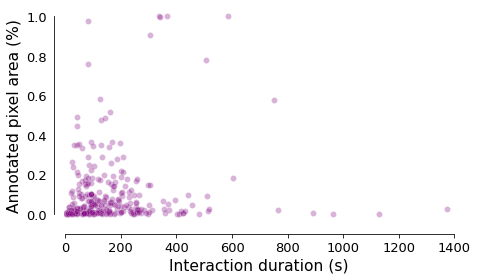

In [39]:
interactions_for_masks_df.drop(interactions_for_masks_df[interactions_for_masks_df['interaction_duration'] > 1400].index, inplace=True)

sns.set_style({
    'xtick.top': False,
    'ytick.right': False,
})

f, ax = plt.subplots(figsize=(7, 4))

g = sns.scatterplot(
    x="interaction_duration", y="annotated_pixels_percentage",
    color="Purple",
    alpha=.3,
    sizes=(6.5, 6.5),
    data=interactions_for_masks_df, ax=ax)

ax.set(xlabel="Interaction duration (s)")
ax.set(ylabel="Annotated pixel area (%)")

ax.set_xlim([-5, 1400])

sns.despine(offset=10, trim=True)

plt.savefig(f"plots_png/duration_area.png", bbox_inches='tight')
plt.savefig(f"plots_pdf/duration_area.pdf", format='pdf', bbox_inches='tight')
plt.show()